In [ ]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


#### SP 500 table

In [ ]:
tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")

In [ ]:
SP_df = tables[0]

In [ ]:
SP_df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [ ]:
sector_dict = dict(zip(SP_df['Symbol'], SP_df['GICS Sector']))
sector_lst = SP_df['GICS Sector'].unique()

## Portfolio Return

In [ ]:
#  1.  Create dataframe yf_price with yf.download
yf_SP500_raws = yf.download(
        tickers = SP_df['Symbol'].tolist(),       # tickers list or string as well
        period = '1y',      # optional, default is '1mo'
        interval = '1d',  # fetch data by intervaal
        group_by = 'ticker',     # group by ticker
        auto_adjust = True,      # adjust all OHLC (open-high-low-close)
        prepost = True,          # download market hours data
        threads = True,          # threads for mass downloading
        proxy = None)            # proxy


[*********************100%%**********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=1y)')


In [ ]:
#  2.  Select 'Close' (price at market close) column only
yf_returns = yf_SP500_raws.iloc[:, yf_SP500_raws.columns.get_level_values(1)=='Close']

In [ ]:
#  3.  Remove the dataframe multi-index
yf_returns.columns = yf_returns.columns.droplevel(1)  # multi-index

In [ ]:
#  4.  calculate percentage changes with "pct_change()"
#  multiply by 100 to get percentage value
#  round off the percentages to 2 decimal points
yf_returns = round(yf_returns.pct_change()*100, 2)


yf_returns.tail(3)

Ticker,T,GWW,GM,AVY,MKTX,LUV,EL,GEN,PLD,HII,...,CLX,BIO,PAYX,STX,AAL,AXON,TRMB,TSN,SYK,BKR
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-14,0.00,0.01,0.00,0.01,-0.01,0.04,0.00,-0.00,-0.00,0.02,...,-0.01,0.04,0.01,-0.00,0.02,0.02,0.04,0.01,0.03,-0.01
2024-02-15,0.01,-0.00,0.02,0.01,0.02,0.01,0.02,0.01,0.02,0.02,...,0.00,0.00,0.00,0.02,0.00,0.01,0.03,0.01,-0.00,0.01
2024-02-16,-0.01,-0.01,-0.01,0.00,-0.01,-0.01,0.01,-0.00,0.00,0.00,...,-0.01,0.04,0.00,-0.01,-0.02,-0.01,0.00,0.01,0.00,-0.00


In [ ]:
yf_returns = yf_returns.dropna(how='all', axis=1).dropna(how='all', axis=0).dropna(how='any', axis=1)
yf_returns.head(3)

Ticker,T,GWW,GM,AVY,MKTX,LUV,EL,GEN,PLD,HII,...,CMI,LRCX,CAT,MCHP,LOW,OKE,PXD,HES,ALL,KEY
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-21 00:00:00+00:00,-0.01,-0.03,-0.05,-0.02,0.00,-0.05,-0.01,-0.01,-0.01,-0.01,...,-0.02,-0.04,-0.03,-0.03,-0.05,-0.02,-0.01,0.00,-0.00,-0.03
2023-02-22 00:00:00+00:00,0.01,0.00,-0.01,0.02,-0.01,-0.00,-0.00,-0.01,-0.00,-0.01,...,-0.01,-0.00,-0.01,-0.01,0.00,0.00,-0.00,-0.01,-0.01,-0.02
2023-02-23 00:00:00+00:00,-0.00,0.00,-0.04,-0.00,-0.01,0.00,0.00,0.00,0.01,-0.01,...,-0.00,0.02,0.00,0.02,-0.00,0.02,-0.00,0.01,-0.01,-0.00


#### Dividend

In [ ]:
yf_divdend = pd.DataFrame()   # initialize dataframe

for i in SP_df['Symbol']:
  try:
    x = pd.DataFrame(yf.Ticker(i).history(period = '1y', interval = '1d')['Dividends'])
    x = x.rename(columns={"Dividends":i})
    yf_divdend = pd.concat([yf_divdend,x], axis=1)
  except:
    continue

ERROR:yfinance:BRK.B: No data found, symbol may be delisted
ERROR:yfinance:BF.B: No price data found, symbol may be delisted (period=1y)


In [ ]:
yf_divdend = yf_divdend.dropna(how='all', axis=1).dropna(how='all', axis=0).dropna(how='any', axis=1)

In [ ]:
yf_divdend.head(5)

,MMM,ATO,BBWI,CTSH,DUK,EMR,GEN,HSY,IP,MSCI,OTIS,PPG,TEL,TER
Date,,,,,,,,,,,,,,
2023-02-16 00:00:00-05:00,1.5,0.74,0.2,0.29,1.005,0.52,0.125,1.036,0.463,1.38,0.29,0.62,0.56,0.11
2023-02-17 00:00:00-05:00,0.0,0.00,0.0,0.00,0.000,0.00,0.000,0.000,0.000,0.00,0.00,0.00,0.00,0.00
2023-02-21 00:00:00-05:00,0.0,0.00,0.0,0.00,0.000,0.00,0.000,0.000,0.000,0.00,0.00,0.00,0.00,0.00
2023-02-22 00:00:00-05:00,0.0,0.00,0.0,0.00,0.000,0.00,0.000,0.000,0.000,0.00,0.00,0.00,0.00,0.00
2023-02-23 00:00:00-05:00,0.0,0.00,0.0,0.00,0.000,0.00,0.000,0.000,0.000,0.00,0.00,0.00,0.00,0.00


In [ ]:
yf_returns.index = pd.to_datetime(yf_returns.index, format='%Y%m%d', utc=True)
yf_divdend.index = pd.to_datetime(yf_divdend.index, format='%Y%m%d', utc=True)

yf_returns.index = yf_returns.index.date
yf_divdend.index = yf_divdend.index.date

In [ ]:
#  match dates in yf_returns (first return data to now)
yf_divdend = yf_divdend[yf_divdend.index >= yf_returns.index[0]]


#  print out dividends
yf_divdend.tail(3)

,MMM,ATO,BBWI,CTSH,DUK,EMR,GEN,HSY,IP,MSCI,OTIS,PPG,TEL,TER
2024-02-14,0.00,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.00,0.00,0.00,0.00
2024-02-15,1.51,0.0,0.0,0.0,1.025,0.525,0.125,0.00,0.0,1.6,0.34,0.65,0.59,0.12
2024-02-16,0.00,0.0,0.0,0.3,0.000,0.000,0.000,1.37,0.0,0.0,0.00,0.00,0.00,0.00


In [ ]:
yf_returns_div = yf_returns.add(yf_divdend, fill_value = 0)

In [ ]:
yf_returns_div_T = yf_returns_div.transpose()
yf_returns_div_T = yf_returns_div_T.reset_index(drop=False).rename(columns={'index':'Symbol'})
yf_returns_div_T['Sector'] = yf_returns_div_T['Symbol'].apply(lambda x: sector_dict.get(x, None))

In [ ]:
yf_sector_returns_T = yf_returns_div_T.groupby(['Sector']).mean()
yf_sector_returns = yf_sector_returns_T.transpose()
yf_sector_returns.head()

<ipython-input-102-07df16ed7e40>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yf_sector_returns_T = yf_returns_div_T.groupby(['Sector']).mean()


Sector,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
2023-02-21,-0.024545,-0.027885,-0.002187,-0.005455,-0.020725,-0.016491,-0.027042,-0.024677,-0.0264,-0.019655,-0.016333
2023-02-22,0.002727,0.003846,-0.002812,-0.000909,-0.001739,-0.002456,0.000563,-0.002419,0.0096,-0.007586,-0.005000
2023-02-23,-0.004091,-0.004231,-0.002812,0.016364,0.000870,0.002632,0.006338,0.014355,0.0044,0.010690,-0.003333
2023-02-24,-0.018182,-0.014423,-0.005000,0.004091,-0.000725,-0.013509,-0.006197,-0.018226,0.0016,-0.015172,0.000333
2023-02-27,0.002727,0.005000,-0.000625,0.002727,-0.001304,-0.002632,0.004930,0.004355,0.0048,-0.000345,-0.006667


#### Annualized Return

In [ ]:
yf_returns_T = yf_returns.transpose()
yf_returns_T = yf_returns_T.reset_index(drop=False).rename(columns={'index':'Ticker'})
yf_returns_T['Sector'] = yf_returns_T['Ticker'].apply(lambda x: sector_dict.get(x, None))
yf_sector_returns = yf_returns_div_T.groupby(['Sector']).mean().transpose()

annulized_sector_return = pd.DataFrame(((1 + yf_sector_returns).prod() - 1) * 100, columns=['Annualized Return Rate'])
annulized_sector_return = annulized_sector_return.reset_index()
annulized_sector_return

<ipython-input-183-3b345817964f>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yf_sector_returns = yf_returns_div_T.groupby(['Sector']).mean().transpose()


,Sector,Annualized Return Rate
0,Communication Services,13.533198
1,Consumer Discretionary,13.931813
2,Consumer Staples,11.778699
3,Energy,11.859235
4,Financials,18.261870
5,Health Care,6.427713
6,Industrials,38.632822
7,Information Technology,43.210667
8,Materials,19.834437
9,Real Estate,-0.392482


In [ ]:
annulized_sector_return_dict = dict(zip(annulized_sector_return['Sector'], annulized_sector_return['Annualized Return Rate']))

#### Covariance

## Portfolio Risk(standard deviation)

In [ ]:
#  1.  Create dataframe yf_price with yf.download
yf_raw = yf.download(
        tickers = SP_df['Symbol'].tolist(),       # tickers list or string as well
        period = '1y',      # optional, default is '1mo'
        interval = '1d',  # fetch data by intervaal
        group_by = 'ticker',     # group by ticker
        auto_adjust = True,      # adjust all OHLC (open-high-low-close)
        prepost = True,          # download market hours data
        threads = True,          # threads for mass downloading
        proxy = None)            # proxy


[*********************100%%**********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=1y)')


In [ ]:
#  2.  Select 'Close' (price at market close) column only
yf_adjClose = yf_SP500_raws.iloc[:, yf_SP500_raws.columns.get_level_values(1)=='Close']

In [ ]:
#  3.  Remove the dataframe multi-index
yf_adjClose.columns = yf_adjClose.columns.droplevel(1)  # multi-index

In [ ]:
yf_adjClose.head(3)

Ticker,T,GWW,GM,AVY,MKTX,LUV,EL,GEN,PLD,HII,...,CLX,BIO,PAYX,STX,AAL,AXON,TRMB,TSN,SYK,BKR
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-17,18.182743,670.779724,42.712288,179.339569,351.062897,34.574081,248.984070,20.499380,121.883621,219.460068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-21,17.967615,649.824951,40.693920,175.900192,351.141907,33.009647,246.138611,20.207085,120.094086,216.997101,...,154.419998,468.160004,111.519997,67.080002,15.69,189.770004,53.119999,60.720001,261.220001,30.129999
2023-02-22,18.126621,651.320374,40.456467,179.290436,347.376007,32.853199,245.409988,20.051197,119.529984,215.755844,...,154.460007,476.000000,110.680000,66.389999,15.56,193.589996,52.980000,61.740002,261.649994,30.049999


In [ ]:
#  4.  calculate percentage changes with "pct_change()"
#  multiply by 100 to get percentage value
#  round off the percentages to 2 decimal points
yf_adjClose = round(yf_adjClose.pct_change()*100, 2)


yf_adjClose.head(3)

Ticker,T,GWW,GM,AVY,MKTX,LUV,EL,GEN,PLD,HII,...,CLX,BIO,PAYX,STX,AAL,AXON,TRMB,TSN,SYK,BKR
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-21,-1.18,-3.12,-4.73,-1.92,0.02,-4.52,-1.14,-1.43,-1.47,-1.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-22,0.88,0.23,-0.58,1.93,-1.07,-0.47,-0.30,-0.77,-0.47,-0.57,...,0.03,1.67,-0.75,-1.03,-0.83,2.01,-0.26,1.68,0.16,-0.27


#### Format df to be [Ticker, Risk, Sector]

In [ ]:
yf_risks = pd.DataFrame(yf_adjClose.apply(lambda x: np.std(x), axis=0), columns=['Risk'])

In [ ]:
yf_risks = yf_risks.reset_index()

In [ ]:
yf_risks['Sector'] = yf_risks.apply(lambda x: sector_dict.get(x['Ticker'], None), axis=1)

In [ ]:
yf_risks.head(5)

,Ticker,Risk,Sector
0,T,1.690324,Communication Services
1,GWW,1.413736,Industrials
2,GM,2.048541,Consumer Discretionary
3,AVY,1.312924,Materials
4,MKTX,2.385258,Financials


#### Combined Risk

In [ ]:
risk_dict = dict(zip(yf_risks['Ticker'], yf_risks['Risk']))

In [ ]:
from itertools import combinations

In [ ]:
ticker_set = set(yf_returns.columns.tolist()).intersection(set(yf_risks['Ticker']))

In [ ]:
yf_returns_intersect = yf_returns[list(ticker_set)]
yf_risk_intersect = yf_risks[yf_risks['Ticker'].isin(ticker_set)]

In [ ]:
Sector_risk_lst = []

for sector in sector_lst:
  ticker_tmp = yf_risk_intersect[yf_risk_intersect['Sector']==sector]
  comb = combinations(yf_risk_intersect[yf_risk_intersect['Sector']==sector]['Ticker'], 2)
  sum_dev = 0
  for ticker in ticker_tmp['Ticker']:
    sum_dev += (risk_dict.get(ticker)*risk_dict.get(ticker))*(1/len(ticker_tmp))*(1/len(ticker_tmp))
  for (tick1, tick2) in comb:
    sum_dev += 2*(np.cov(yf_returns_intersect[tick1], yf_returns_intersect[tick2])[0][1])*(1/len(ticker_tmp))**4

  sector_std = np.sqrt(sum_dev)*100
  Sector_risk_lst.append(sector_std)
  print(f"Sector - {sector} risk: {sector_std}")

Sector - Industrials risk: 19.843493724643583
Sector - Health Care risk: 23.574920945810966
Sector - Information Technology risk: 25.297909621780274
Sector - Utilities risk: 24.978800121371812
Sector - Financials risk: 22.567560333965314
Sector - Materials risk: 36.409702038468275
Sector - Consumer Discretionary risk: 27.442535663286577
Sector - Real Estate risk: 30.25889276117394
Sector - Communication Services risk: 42.44281135580632
Sector - Consumer Staples risk: 24.86649959055057
Sector - Energy risk: 38.0555159378278


In [ ]:
Sector_risk_df = pd.DataFrame({'Sector':sector_lst, 'Risk':Sector_risk_lst})

In [ ]:
Sector_risk_df

,Sector,Risk
0,Industrials,19.843494
1,Health Care,23.574921
2,Information Technology,25.297910
3,Utilities,24.978800
4,Financials,22.567560
5,Materials,36.409702
6,Consumer Discretionary,27.442536
7,Real Estate,30.258893
8,Communication Services,42.442811
9,Consumer Staples,24.866500


In [ ]:
Sector_risk_dict = dict(zip(Sector_risk_df['Sector'], Sector_risk_df['Risk']))

## Sharpe Ratio

From the graph below, we see the long term risk free rate is 4.25%

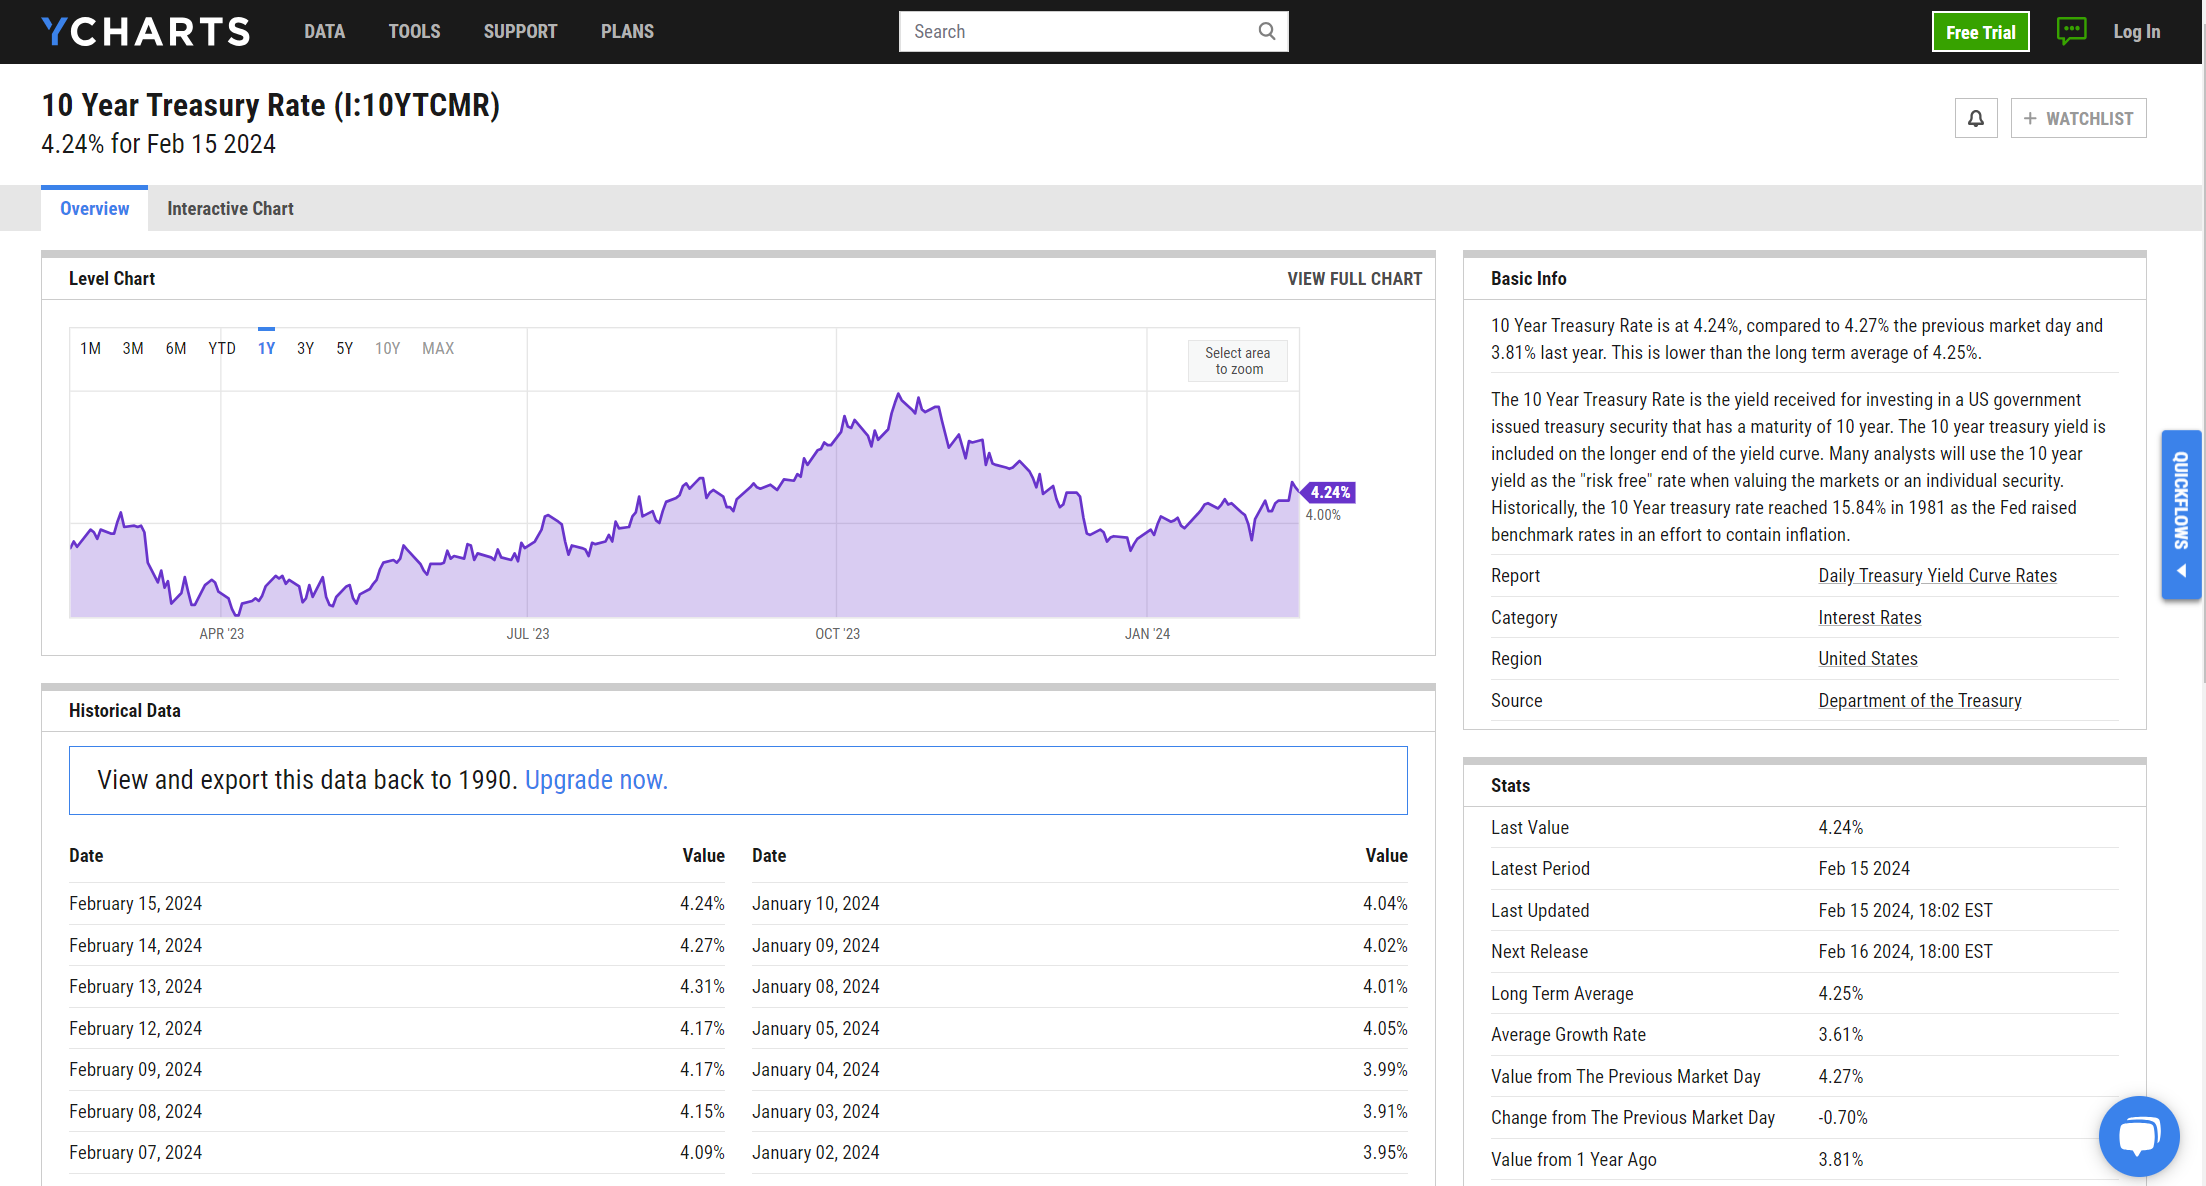

In [ ]:
rfr = 0.0425

#### Suppose we have correct calculation of Sector Portfolio return and risk

In [ ]:
for sector in annulized_sector_return['Sector']:
  print(f" Sector-{sector} sharpe ratio: {(annulized_sector_return_dict[sector] - rfr)/Sector_risk_dict[sector]}")

 Sector-Communication Services sharpe ratio: 0.3178559058381337
 Sector-Consumer Discretionary sharpe ratio: 0.5061235308925122
 Sector-Consumer Staples sharpe ratio: 0.471968276626922
 Sector-Energy sharpe ratio: 0.3105130648475927
 Sector-Financials sharpe ratio: 0.8073256230561748
 Sector-Health Care sharpe ratio: 0.27084770281843984
 Sector-Industrials sharpe ratio: 1.9447342419079043
 Sector-Information Technology sharpe ratio: 1.7063926640721443
 Sector-Materials sharpe ratio: 0.5435896536465843
 Sector-Real Estate sharpe ratio: -0.014375346122631714
 Sector-Utilities sharpe ratio: 0.7701193030143234


In [ ]:
Sector_df = Sector_risk_df.merge(annulized_sector_return, on='Sector')
Sector_df['Sharpe Ratio'] = Sector_df.apply(lambda x: (x['Annualized Return Rate']-rfr)/x['Risk'], axis=1)
Sector_df

,Sector,Risk,Annualized Return Rate,Sharpe Ratio
0,Industrials,19.843494,38.632822,1.944734
1,Health Care,23.574921,6.427713,0.270848
2,Information Technology,25.297910,43.210667,1.706393
3,Utilities,24.978800,19.279156,0.770119
4,Financials,22.567560,18.261870,0.807326
5,Materials,36.409702,19.834437,0.543590
6,Consumer Discretionary,27.442536,13.931813,0.506124
7,Real Estate,30.258893,-0.392482,-0.014375
8,Communication Services,42.442811,13.533198,0.317856
9,Consumer Staples,24.866500,11.778699,0.471968



---


## Second tryout

In [ ]:
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tables = pd.read_html(url)
sp500_companies = tables[0]
ticker_to_sector = dict(zip(sp500_companies['Symbol'], sp500_companies['GICS Sector']))

In [ ]:
import seaborn as sns

In [ ]:
from itertools import combinations
import numpy as np

In [ ]:
import yfinance as yf

tickers = sp500_companies['Symbol'].tolist()
data = yf.download(tickers, start='2023-01-01', end='2024-01-01')['Adj Close']

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-01-01 -> 2024-01-01)')


#### Return

In [ ]:
daily_returns = data.pct_change().dropna(how='all', axis=1).dropna(how='all', axis=0)

<Axes: xlabel='Ticker', ylabel='Date'>

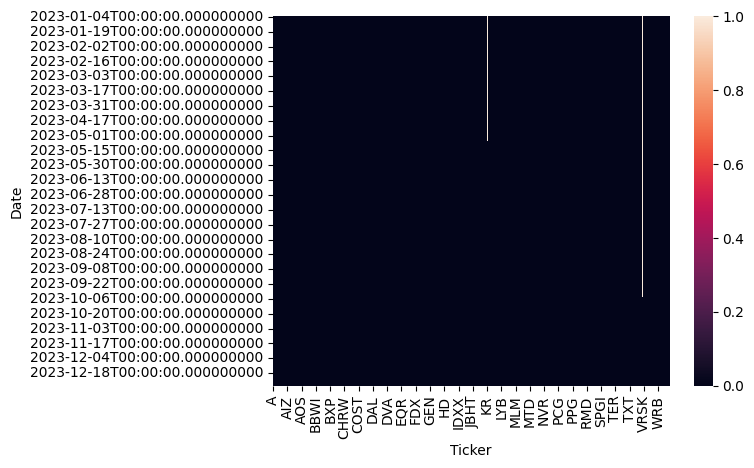

In [ ]:
sns.heatmap(daily_returns.isnull())

In [ ]:
# Calculate the ratio of null values for each column
null_ratio = daily_returns.isnull().mean()

# Filter out columns with a null value ratio above 20%
filtered_columns = null_ratio[null_ratio <= 0.2].index

# Keep only the filtered columns in the DataFrame
daily_returns_filtered = daily_returns[filtered_columns]

daily_returns_filtered

In [ ]:
average_daily_return = daily_returns_filtered.mean()
annualized_return = (1 + average_daily_return) ** 252 - 1

In [ ]:
annualized_sector_return = annualized_return.groupby(by=ticker_to_sector).mean()
annualized_sector_return

Ticker
Communication Services    0.347865
Consumer Discretionary    0.374091
Consumer Staples         -0.016390
Energy                    0.138898
Financials                0.177313
Health Care               0.087485
Industrials               0.320618
Information Technology    0.541062
Materials                 0.156938
Real Estate               0.162669
Utilities                 0.004690
dtype: float64

#### Covariance

In [ ]:
covariance_matrix = daily_returns_filtered.cov()
correlation_matrix = daily_returns_filtered.corr()

#### Risk

In [ ]:
risk = daily_returns_filtered.std()

In [ ]:
sector_risk = []

for sector in sp500_companies['GICS Sector'].unique():
  std_sum = 0
  tickers = [ticker for ticker in ticker_to_sector if ticker_to_sector.get(ticker)==sector and ticker in daily_returns_filtered]
  for ticker in tickers:
    std_sum += 1/len(tickers) * 1/len(tickers) * risk[ticker] * risk[ticker]
  com = combinations(tickers, 2)
  for (tick1, tick2) in com:
    std_sum += 2 * 1/len(tickers) * 1/len(tickers) * covariance_matrix[tick1][tick2]

  risk_tmp = np.sqrt(std_sum)
  sector_risk.append(risk_tmp)
  print(sector, risk_tmp)

sector_risk_df = pd.DataFrame(sector_risk, columns=['Risk'], index=sp500_companies['GICS Sector'].unique())
sector_risk_df

Industrials 0.010062489909443187
Health Care 0.008465114048282337
Information Technology 0.012059428489852801
Utilities 0.011086713964973002
Financials 0.011946511842430105
Materials 0.011588575186660195
Consumer Discretionary 0.011614172491138297
Real Estate 0.012985807168731347
Communication Services 0.011285780365544609
Consumer Staples 0.007411912265688891
Energy 0.015005505694703596


,Risk
Industrials,0.010062
Health Care,0.008465
Information Technology,0.012059
Utilities,0.011087
Financials,0.011947
Materials,0.011589
Consumer Discretionary,0.011614
Real Estate,0.012986
Communication Services,0.011286
Consumer Staples,0.007412


#### Sharpe Ratio

In [ ]:
rfr = 0.0419

In [ ]:
(annualized_sector_return-rfr)/sector_risk_df.squeeze()

Communication Services    27.110661
Consumer Discretionary    28.602199
Consumer Staples          -7.864368
Energy                     6.464144
Financials                11.334954
Health Care                5.385005
Industrials               27.698675
Information Technology    41.391805
Materials                  9.926823
Real Estate                9.300079
Utilities                 -3.356254
dtype: float64